# Covariance matrix change-point detection under graph stationarity assumption


## Problem formulation

Let $y = (y_1, \ldots, y_t, \ldots, y_T), y_t \in \mathbb{R}^{N}$ a graph signal lying on the nodes of the graph $G = (V, E, W)$, with $N =|V|$.

We aim at detecting changes of the (spatial) covariance matrix $\Sigma_t$ of the graph signals $y_t$. We assume that there exits an unknown set of change-points $\Tau = (t_1, \ldots, t_K) \subset [1, T]$ with unknown cardinality such that the covariance matrix of the graph signals is constant over any segment $[t_k, t_{k+1}]$. We do the following hypothesis:

1. the signals $y_t$ follow a multivariate Gaussian distribution with fixed covariance matrix over each segment and known mean $\mu$, i.e:
$$\forall k \in [1, K] ~ \forall t \in [t_k, t_{k+1}] \quad y_t \sim \mathcal{N}(\mu, \Sigma_k)$$

2. over each segment, the signals $y_t$ verify the second order wide-sense graph stationarity:
$$\forall k \in [1, K] \quad \Sigma_k = U \text{diag}(\gamma_k)U^T $$

where the matrix $U$ contains the eigenvectors of the graph combinatorial Laplacian matrix $L = D - W$ in its columns. 

The Graph Fourier Transform $\tilde{y}$ of a signal $y$ is defined by $\tilde{y} = U^T y $.


Based on the above assumptions, the cost derived from the maximum log-likelihood over a segment $[a, b-1]$ writes:

\begin{align*}
    c_s(y_{a}, \ldots, y_{b-1}) = ~ & (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + ~ \sum_{t=a}^{b-1} \sum_{n=1}^N \frac{\left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2}{\hat{\gamma}_{a.b}^{(n)}} = ~ (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + N(b-a)
\end{align*}

where:

- $\hat{\mu}_{T}$ is the empirical mean of the process over $[0, T]$
- $\hat{\gamma}^{(n)}_{a..b}$ is the (empirical) biased correlogram/periodogram of the process over $[a, b-1]$: $\hat{\gamma}_{a..b} = \frac{1}{(b-a)} \sum_{t=a}^{b-1} \left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2$

## Experimental setup

In [34]:
import os
import warnings
import time

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

from datetime import datetime
from pathlib import Path
from tqdm import tqdm
from typing import List
from matplotlib.lines import Line2D

import utils as my_ut
import graph_related as my_gr
import signal_related as my_sgn
import result_related as my_res
import running_cpd as my_cpd

### Graph generation

We designed three graph generation scenarios, based on common examples found in the literature (\textbf{cite}). All these scenarios are controlled by hyper-parameters so that we can precisely identify the influence of any factor. Also, all the random effects are seeded for reproducibility (\textbf{reproductivity ??}) and we use the library $\texttt{networkx}$ to produce the graphs..

1. Erdős–Rényi (ER) graphs with random parameters

In the first scenario, we generate ER graphs (\textbf{cite}) with a given number of nodes $N$ and a target mean degree $d$. The edge probability $p$ is deduced from $d$, so it is uniformly drawn in $[p_{\min}, p_{\max}]$ with $p_{\min} = (1 - \sigma_p) * \frac{d}{N-1}$ and $p_{\max} = (1 + \sigma_p) * \frac{d}{N-1}$. The hyper-parameter $\sigma_p$ is a bandwidth coefficient, allowing for more diversity in the graph connectivity.

2. Geographic-like graphs 


The nodes of geographic-like graphs are randomly drawn following $\mathcal{U}([0, 1]^2)$ and their connectivity rely on a measure of the distance between nodes. Two sub-scenarios were explored regarding this distance measure, but both of them depend on a number of nodes $N$ and a target mean degree $d$.

We pick a random number $N$ of nodes uniformly drawn in $[N_{\min}, N_{\max}]$. The nodes are randomly located in $[0, 1]^2$ using the uniform law $\mathcal{U}([0, 1]^2)$. Eventually, we build the adjacency matrix of the graph by applying a threshold $\rho$ to the distance separating the nodes. More formally, if we denote $(W_{ij})_{1 \leq i, j \leq N}$ the coefficients of the adjacency matrix, we explore the following two formulas:

In [ ]:
N_EXP = 1000
GRAPH_SEED = 1
N_NODES = 20
TARGET_DEGREE = 10
K_NEIGHBOUR = 8
ER_BANDWIDTH = 0.4
EDGE_PROP_TO_MODIF = 2.0
EDGE_PROP_TO_REMOVE = 0.7
EDGE_PROP_TO_ADD = 0.7
INITIAL_GRAPH_PATH = "data_1/synthetic_data/graphs/clean_ER_with_bandwidth"
INIT_NAME = "ER_20_nodes_deg_10_bandwidth_0.4"
TARGET_GRAPH_PATH = 'data_1/synthetic_data/graphs/ER_with_bandwidth_edges_added'

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
graph_rng = np.random.default_rng(seed=GRAPH_SEED)
to_modify_graph_path = os.path.join(INITIAL_GRAPH_PATH, INIT_NAME)

# logging
NAME =  INIT_NAME + '_' + f'edge_prop_{EDGE_PROP_TO_ADD}'
data_dir = os.path.join(TARGET_GRAPH_PATH, NAME) 
graphs_desc = f"Graphs fetched from {to_modify_graph_path}. The connectivity of the graphs is modified: we randomly add a proportion of edges."
# graph_gen_func = lambda rng : my_gr.generate_random_geographic_graph_with_gauss_kernel(rng, n_nodes=N_NODES, target_degree=TARGET_DEGREE)
# graph_modif_func = lambda exp_id : my_gr.load_modify_connec_and_store_graph(to_modify_graph_path, exp_id, EDGE_PROP_TO_MODIF, graph_rng, data_dir)
graph_modif_func = lambda exp_id : my_gr.load_add_edges_and_store_graph(to_modify_graph_path, exp_id, EDGE_PROP_TO_ADD, graph_rng, data_dir)
graphs_metadata = {"datetime": now, "description": graphs_desc, "commit hash": my_ut.get_git_head_short_hash(), "graph_modif_func": my_gr.load_add_edges_and_store_graph.__name__, "graph_seed": GRAPH_SEED, "nx_graph_seed": "index", "n_nodes": N_NODES, "K_NEIGHBOUR": K_NEIGHBOUR, "added edge proportion": EDGE_PROP_TO_ADD}

# output formatting
Path(data_dir).mkdir(parents=True, exist_ok=False)
graphs_metadata = my_ut.turn_all_list_of_dict_into_str(graphs_metadata)
my_ut.create_parent_and_dump_json(data_dir, "00_graphs_metadata.json", graphs_metadata, indent=4)

# graph generation
for exp_id in range(N_EXP):
    graph_modif_func(exp_id)
    # G, coords = graph_gen_func(graph_rng)
    # my_ut.save_graph(G, f"{data_dir}/{exp_id}_mat_adj.npy")

### Signal and bkps generation

Let $G$ be a graph randomly generated using one of the above scenarios. We recall that the laplacian matrix $L$ of the graph verifies $L = U \Lambda U^T$, where the columns of $U$ are the eigenvectors of $L$. We now describe how to generate a signal $(y_t)_{1 \leq t \leq T}$ that verifies the hypothesis presented in the [problem formulation](#problem-formulation).

We first pick an admissible number of change points $K$ depending on the signal length $T=1000$ and the minimum segment length $l = N$. The change points $(t_k)_{1 \leq k \leq K}$ are uniformly drawn in $[l, T-l]$, by checking that a newly selected change point does not break the minimum segment length criteria. Finally, we apply the following formula to generate the signal $(y_t)_{1 \leq t \leq T}$:

$$ \forall ~ k \in [1, K-1] ~ \forall  t \in [t_k, t_{k+1}] \quad  y_t \sim \mathcal{N}_N(0, \Sigma_k) \quad \text{ with } \quad \Sigma_k = U \text{diag}(\gamma_k) U^T ~  \text{ and } ~ \gamma_k \sim \mathcal{U}niform_N([0, 1]) $$

In [13]:
GRAPH_FOLDER =  "data_1/synthetic_data/graphs/clean_KNN_geo"
GRAPH_FOLDER_NAME =  "KNN_geo_20_nodes_K_8"
GRAPH_PATH = os.path.join(GRAPH_FOLDER, GRAPH_FOLDER_NAME)
SIGNAL_SEED = 3
DIAG_COV_MAX = 1
N_SAMPLES = 1000
MIN_SEGMENT_LENGTH_COEF = 0.4
BKPS_GAP_CONSTRAINT: my_ut.seg_length = "large" 
NB_BREAKDOWN = 2
BREAKDOWN_LENGTH = 300
SNR_LIST = [20]

TARGET_DIR =  f"data_1/synthetic_data/signal/within_hyp/SNR_20_varying_segment_length"

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
signal_rng = np.random.default_rng(seed=SIGNAL_SEED)

breakdowns_dic = {}

for SNR in SNR_LIST:

    sigma_noise = DIAG_COV_MAX / ( 10**(SNR / 10) )
    
    # logging
    NAME = f"{BKPS_GAP_CONSTRAINT}_x{MIN_SEGMENT_LENGTH_COEF}_SNR_{round(SNR, 4)}" + "_" + GRAPH_FOLDER_NAME  # f"_NBbd_{NB_BREAKDOWN}_bklength_{BREAKDOWN_LENGTH}" + 
    data_dir = TARGET_DIR + '/' + NAME
    signal_desc = "Data verifying the two hypothesis, with a given number of bkps fixed by a coefficient applied to the large segment length. A small additive white noise is applied."
    signal_gen_func = lambda G : my_sgn.generate_rd_signal_in_hyp_with_fixed_min_size(G, signal_rng, hyp=BKPS_GAP_CONSTRAINT, n_samples=N_SAMPLES, min_size_coef=MIN_SEGMENT_LENGTH_COEF, diag_cov_max=DIAG_COV_MAX)
    signal_modif_func = lambda s : my_sgn.add_diagonal_white_noise(signal_rng, s, sigma=sigma_noise)
    # signal_modif_func2 = lambda s : my_sgn.modify_signal_to_simulate_breakdown(s, signal_rng, n_breakdown=NB_BREAKDOWN, breakdown_length=BREAKDOWN_LENGTH)
    signal_metadata = {"datetime": now, "description": signal_desc, "commit hash": my_ut.get_git_head_short_hash(), "graph_folder": GRAPH_PATH, "signal_seed": SIGNAL_SEED, "signal_gen_function": my_sgn.generate_rd_signal_in_hyp_with_fixed_min_size.__name__, "n_samples": N_SAMPLES, "diag_cov_max": DIAG_COV_MAX, "min_size_coef": MIN_SEGMENT_LENGTH_COEF, "bkps_gap_hyp": BKPS_GAP_CONSTRAINT, "signal_modif_func": my_sgn.add_diagonal_white_noise.__name__, "SNR": SNR} #, "n_bkps": N_BKPS} #, "nb brakdown": NB_BREAKDOWN, "breakdown length": BREAKDOWN_LENGTH}

    # output formatting
    Path(data_dir).mkdir(parents=True, exist_ok=False)
    signal_metadata = my_ut.turn_all_list_of_dict_into_str(signal_metadata)
    my_ut.create_parent_and_dump_json(data_dir, "00_signal_metadata.json", signal_metadata, indent=4)

    # signal generation
    for exp_id in range(len(os.listdir(GRAPH_PATH)) - 1):
        adj_mat = np.load(f"{GRAPH_PATH}/{exp_id}_mat_adj.npy", allow_pickle=False)
        G = nx.from_numpy_array(adj_mat)
        bkps, signal = signal_gen_func(G)
        signal_modif = signal_modif_func(signal)
        # signal_modif2, breakdowns = signal_modif_func2(signal_modif)
        # breakdowns_dic[exp_id] = breakdowns
        my_ut.save_signal_and_bkps(signal_modif, bkps, data_dir, str(exp_id))

    # my_ut.create_parent_and_dump_json(data_dir, "00_breakdowns_dict.json", breakdowns_dic, indent=4)

## Experiments description and visualization

##### A. Robustness with respect to (spatially and temporaly) independent additive white noise

In this experiment, we keep using signals that verify our two hypothesis. Though we add a temporally independent white noise with scalar covariance matrix to such signal. More formally, we apply the change point detection algorithm to the signal $(y'_t)_{1 \leq t \leq T}$ defined by

\begin{equation}
    \forall ~  t \in [0, T] \quad y'_t = y_t + e_t \quad \text{ with } \quad e_t \sim \mathcal{N}_N(0, \sigma)
\end{equation}

We evaluate the performance of our cost function against increasing value of $\sigma$.

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 5

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

# generating noisy signal
G, _ = my_gr.generate_random_geographic_graph_with_gauss_kernel(graph_rng, n_nodes=20, target_degree=10)
bkps, s = my_sgn.generate_rd_signal_in_hyp_with_max_tries(G, signal_rng, n_bkps_max=10, n_samples=G.number_of_nodes()**2, hyp='minimal', diag_cov_max=1)
s_noise = my_sgn.add_diagonal_white_noise(signal_rng, s, sigma=3)

# loading noisy signal
signal_path_no_noise = 'data_1/synthetic_data/signal/within_hyp/varying_segment_length/large_x0.4_ER_20_nodes_deg_10_bandwidth_0.4'
signal_no_noise = np.load(f"{signal_path_no_noise}/{0}_signal.npy", allow_pickle=False)
signal_path_noise = 'data_1/synthetic_data/signal/within_hyp/varying_SNR_within_hyp/large_x0.4_SNR_0_ER_20_nodes_deg_10_bandwidth_0.4'
signal_noise = np.load(f"{signal_path_noise}/{0}_signal.npy", allow_pickle=False)


fig, axes = plt.subplots(1, 2, figsize=(12, 2))
for i in range(5):
    axes[0].plot(10*i+s[:, i])
for i in range(5):
    axes[1].plot(10*i+s_noise[:, i])


##### B. Influence of the graph knowledge: modification of the connectivity

In this experiment, we do not generate the signal $(y_t)_{1 \leq t \leq T}$ with the graph $G$ that is used to compute the cost function. Instead, we rather utilize the laplacian matrix $L_{noisy}$ of a noisy version $G_{noisy}$ of the original graph $G$.

Let denote $M = |E|$ the number of edges in $G$ and $\eta_{edge}$ the proportion of edges that we modify. We randomly remove $M_{remove} = \lfloor M * \eta_{edge} / 2 \rfloor$ from the set E and we randomly add $M_{add} = \lfloor M * \eta_{edge} / 2 \rfloor$ to $E$. In both cases, we select the edges randomly, but we always check that the resulting noisy graph $G_{noisy}$ still has the same number of nodes as $G$.

The original graph contained 100 edges.
The modifed graph contains 100 edges.
The effective of modified edges is 1.8.


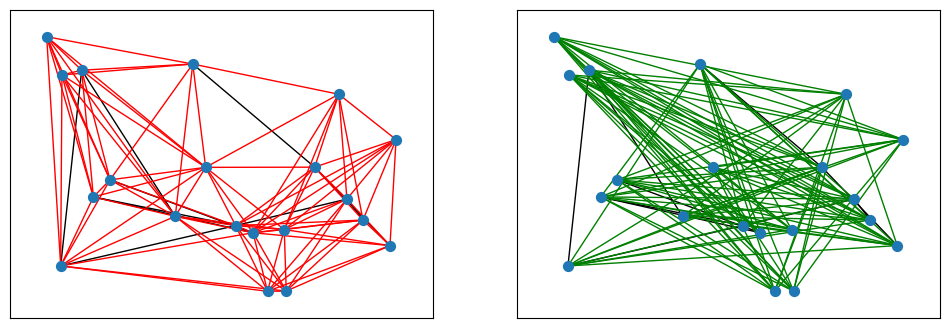

In [31]:
edge_prop = 1.8

nx_graph_seed = 1
graph_seed = 3
signal_seed = 2
signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed+3)

G, coord = my_gr.generate_KNN_random_geographic_graph(graph_rng, n_nodes=20, K=8)
G_modif = my_gr.modify_graph_connectivity_from_binary_adj_mat(G, edge_prop, graph_rng)
bkps, s = my_sgn.generate_rd_signal_in_hyp_with_max_tries(G_modif, signal_rng, n_bkps_max=10, n_samples=G.number_of_nodes()**2, hyp='minimal', diag_cov_max=1)

original_edges = set([(min(e), max(e)) for e in G.edges()])
modif_edges = set([(min(e), max(e)) for e in G_modif.edges()])

added = modif_edges.difference(original_edges)
withdrawn  = original_edges.difference(modif_edges)
same = modif_edges.intersection(original_edges)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# original graph
nx.draw_networkx_edges(G, pos=coord, edgelist=same, edge_color='k', ax=axes[0])
nx.draw_networkx_edges(G, pos=coord, edgelist=withdrawn, edge_color='r', width=1, ax=axes[0])
nx.draw_networkx(G, with_labels=False, pos=coord, node_size=50, ax=axes[0], edgelist = [])
# modified graph
nx.draw_networkx_edges(G_modif, pos=coord, edgelist=same, edge_color='k', ax=axes[1])
nx.draw_networkx_edges(G_modif, pos=coord, edgelist=added, width=1, edge_color='g', ax=axes[1])
nx.draw_networkx(G_modif, with_labels=False, pos=coord, node_size=50, ax=axes[1], edgelist = [])

print(f'The original graph contained {len(original_edges)} edges.')
print(f'The modifed graph contains {len(modif_edges)} edges.')
print(f'The effective of modified edges is {round((len(added) + len(withdrawn))/len(original_edges), 4)}.')

The original graph contained 125 edges.
The modifed graph contains 190 edges.
The effective of modified edges is 0.52.


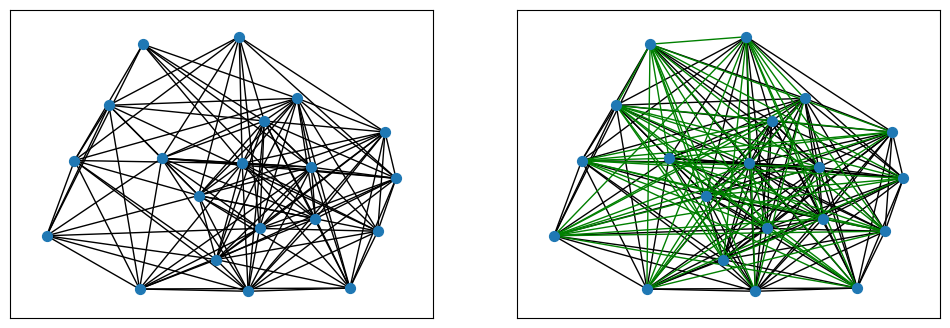

In [25]:
exp_id = 25

ori_path = "data_1/synthetic_data/graphs/clean_ER_with_bandwidth/ER_20_nodes_deg_10_bandwidth_0.4"
adj_mat = np.load(f"{ori_path}/{exp_id}_mat_adj.npy", allow_pickle=False)
G = nx.from_numpy_array(adj_mat)
coord = nx.spring_layout(G, seed=0)
modif_path = "data_1/synthetic_data/graphs/ER_with_bandwidth_edges_added/ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.7"
modif_adj_mat = np.load(f"{modif_path}/{exp_id}_mat_adj.npy", allow_pickle=False)
modif_G = nx.from_numpy_array(modif_adj_mat)

original_edges = set([(min(e), max(e)) for e in G.edges()])
modif_edges = set([(min(e), max(e)) for e in modif_G.edges()])

added = modif_edges.difference(original_edges)
withdrawn  = original_edges.difference(modif_edges)
same = modif_edges.intersection(original_edges)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# original graph
nx.draw_networkx_edges(G, pos=coord, edgelist=same, edge_color='k', ax=axes[0])
nx.draw_networkx_edges(G, pos=coord, edgelist=withdrawn, edge_color='r', width=1, ax=axes[0])
nx.draw_networkx(G, with_labels=False, pos=coord, node_size=50, ax=axes[0], edgelist = [])
# modified graph
nx.draw_networkx_edges(modif_G, pos=coord, edgelist=same, edge_color='k', ax=axes[1])
nx.draw_networkx_edges(modif_G, pos=coord, edgelist=added, width=1, edge_color='g', ax=axes[1])
nx.draw_networkx(modif_G, with_labels=False, pos=coord, node_size=50, ax=axes[1], edgelist = [])

print(f'The original graph contained {len(original_edges)} edges.')
print(f'The modifed graph contains {len(modif_edges)} edges.')
print(f'The effective of modified edges is {round((len(added) + len(withdrawn))/len(original_edges), 4)}.')

##### D. Data verifying the hypothesis of the models, with node dropping to simulate breakdowns

In what follows, we work with signals verifying the two hypothesis from the [the problem formulation](#problem-formulation). Additionally, we will select a given number of nodes and simulate the breakdown of the corresponding sensors by setting the value of the signal lying on this node to 0 for a given time length $\tau_{broken}$. The breakdowns are randomly located both in time and space.

More formally, let denote $N_{broken}$ the hyper-parameter corresponding to the number of nodes that undergo a breakdown. For each signal $(y_t)_{1 \leq t \leq T} \in \mathbb{R}^{T \times N}$ , we draw $N_{broken}$ number of nodes undergoing a breakdown. Then for a node $i$ undergoing a breakdown we apply:

\begin{equation}
    t_{start} ~ \sim ~ \mathcal{U}niform([0, T-\tau_{broken}]), ~ t_{end} = t_{start} + \tau_{broken} \qquad \forall ~  t \in [t_{start}, t_{end}] \quad y_t^{(i)} = 0
\end{equation}

Therefore, by increasing the value of $N_{broken}$ we evaluate the robustness of our cost function with respect to brutal, isolated and uncorrelated mean changes.

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 5

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

G, _ = my_gr.generate_random_er_graphs_fixed_nodes_nb(graph_rng, nx_graph_seed, n_nodes=30, target_deg=10, bandwidth_coef=0.4)
bkps, s = my_sgn.generate_rd_signal_in_hyp_with_max_tries(G, signal_rng, n_bkps_max=10, n_samples=G.number_of_nodes()**2, hyp='minimal', diag_cov_max=1)
s, breakdowns = my_sgn.modify_signal_to_simulate_breakdown(s, signal_rng, n_breakdown=6, breakdown_length=300)

print("The generated breakdowns are:", breakdowns)

fig, ax = plt.subplots(1, 1, figsize=(12,3))
for i in range(5):
    ax.plot(10*i+s[:, i])
for i, node_id in enumerate(breakdowns.keys()):
    ax.plot(10*(i+5)+s[:, node_id])

### Plotting utils

In [3]:
COST_FUNC_NAME_TO_PLOT_LABEL = {
    "statio_pred": "STATIO",
    "standard_mle_pred": "MLE",
    "covcp_windsize_80_stableset_80": "COVCP",
    "lasso_penmultcoef_4.0_pred": "GLASSO"
}

COLORS_PER_COST_FUNC = {
    "statio_pred": "darkorange",
    "standard_mle_pred": "dodgerblue",
    "covcp_windsize_80_stableset_80": "hotpink",
    "lasso_penmultcoef_4.0_pred": "forestgreen"
}

In [4]:
def get_metadata_for_plot(res_path_list):
    metadata = {}
    for serie_id, file_path in enumerate(res_path_list):
        file_information = {}
        files_in_the_res_folder = os.listdir(file_path)
        for file_name in files_in_the_res_folder:
            if 'metadata' in file_name:
                file_information = my_ut.open_json(os.path.join(file_path, file_name))
                metadata[serie_id] = file_information
                break
    return metadata

In [5]:
def fill_per_method_dic_from_met_dic(one_exp_metric_file, stat_per_method):
    # get mean value
    mean = one_exp_metric_file["mean"]
    stat_per_method["mean"].append(mean)
    # get std
    std = one_exp_metric_file["std"]
    stat_per_method["std"].append(std)
    # get raw values
    raw_str = one_exp_metric_file["raw"]
    raw = my_ut.turn_str_of_list_into_list_of_float(raw_str)
    stat_per_method["raw"].append(raw)


In [6]:
def get_res_per_method(res_folder_list, method_keys, metric_name, file_name = 'metrics.json'):
    # initialization
    stat_per_method = {}
    for method_name in method_keys:
        stat_per_method[method_name] = {"mean": [], "std": [], "raw": []}
    # parsing metrics file to store results adequately, i.e per method instead of per experiment
    for folder_name in res_folder_list:
        file_metric = my_ut.open_json(os.path.join(folder_name, file_name))
        for method_name in method_keys:
            # for f1, precsion and recall
            if 'margin' in metric_name:
                one_exp_metric_file = file_metric[method_name][metric_name]['f1_score']
                fill_per_method_dic_from_met_dic(one_exp_metric_file, stat_per_method[method_name])
            # for randindex, haussdorf and assignement_cost
            else:
                one_exp_metric_file = file_metric[method_name][metric_name]
                fill_per_method_dic_from_met_dic(one_exp_metric_file, stat_per_method[method_name])
    return stat_per_method

In [7]:
def add_raw_scatter_to_plot(x, res_dic, met_name, cost_func, ax):
    # scatter plot based on the raw values
    raw = np.array(res_dic[cost_func][met_name]["raw"])
    raw.flatten()
    x_scat_val = []
    for x_id in range(len(x)):
        x_scat_val = x_scat_val + [x[x_id]] * len(raw[x_id])
    ax.scatter(x=x_scat_val, y=raw, alpha=0.3, c='k', s=10)
    return ax

In [8]:
bar_width = 0.21
error_kw = {"capsize": 5, "elinewidth": 0.8, "capthick": 2}

def plot_bar_and_scatter(cost_func_keys, res_dic, abscissa, colors_per_cost_func, met_name, ax, shift= 0.1, to_label=False):
    # plot_x_coord = np.linspace(0, 1, num=(len(abscissa)+1))[:-1]
    for i, cost_func in enumerate(cost_func_keys):
        label = None
        if to_label:
            label = cost_func
        color = colors_per_cost_func[cost_func]
        # bar plot based on the statistics
        x = np.asarray(abscissa) + shift*i
        y = res_dic[cost_func][met_name]["mean"]
        y_err = res_dic[cost_func][met_name]["std"]
        ax.bar(x = x, height=y, yerr=y_err, label=label, width=bar_width, error_kw=error_kw, color=color)
        # scatter plot based on the raw values
        add_raw_scatter_to_plot(x, res_dic, met_name, cost_func, ax)
    return ax

In [9]:
def standard_plot_plus_fill_between(method_keys, res_dic, colors_per_method, ax, to_label=False):
    for method_name in method_keys:
        label_mean = None
        label_std = None
        if to_label:
            label_mean = 'mean ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name] 
            label_std = 'std ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name]
        color = colors_per_method[method_name]
        y = np.asarray(res_dic[method_name]["mean"])
        y_err = np.asarray(res_dic[method_name]["std"])
        x = np.asarray(range(1, len(y)+1))
        ax.plot(x, y, c=color, label=label_mean, marker='x')
        ax.fill_between(x, y1=y-y_err, y2=y+y_err, color=color, alpha=0.3, label=label_std)
    return ax

In [10]:
def standard_plot_plus_fill_between_wrt_margin(method_keys, per_margin_res_dic, colors_per_method, preci_margin_list, ax, to_label=False, alpha=0.3):
    for method_name in method_keys:
        label_mean = None
        label_std = None
        if to_label:
            label_mean = 'mean ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name] 
            label_std = 'std ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name]
        color = colors_per_method[method_name]
        y = np.empty(len(preci_margin_list))
        y_err = np.empty(len(preci_margin_list))
        for i, preci_margin in enumerate(preci_margin_list):
            y[i] = np.asarray(per_margin_res_dic[preci_margin][method_name]["mean"][0])
            y_err[i] = np.asarray(per_margin_res_dic[preci_margin][method_name]["std"][0])
        x = np.asarray(range(1, len(y)+1))
        ax.plot(x, y, c=color, label=label_mean, marker='x')
        ax.fill_between(x, y1=y-y_err, y2=y+y_err, color=color, alpha=alpha, label=label_std, linewidth=0)
    return ax

In [11]:
def add_errorbar_manually(abscissa, y, yerr, marker, linestyle, linewidth, markersize, color, ax):
    # create top and bottom lim
    y_err_top = [y_pos + yerr_val for y_pos, yerr_val in zip(y, yerr)]
    y_err_bottom = [y_pos - yerr_val for y_pos, yerr_val in zip(y, yerr)]
    # add the top and bottom markers
    ax.scatter(abscissa, y_err_top, s=markersize, c=color, marker=marker)
    ax.scatter(abscissa, y_err_bottom, s=markersize, c=color, marker=marker)
    # add the vertical lines
    ax.vlines(x=abscissa, ymin=y_err_bottom, ymax=y_err_top, color=color, linewidth=linewidth, linestyle=linestyle)
    return ax

### Search algorithms: running experiments

In [5]:
NAME =  "ER_20_nodes_deg_10_bandwidth_0.4" 
GRAPH_NAME =  NAME  #+ '_' + "edge_prop_0.2" #"exp_geo_20_nodes_av_deg_10" #"ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.05" 
GRAPH_PATH =   "data_1/synthetic_data/graphs/clean_ER_with_bandwidth"
SIGNAL_PATH = "data_1/synthetic_data/signal/within_hyp/SNR_20_varying_segment_length"
SIGNAL_NAME =  "large_x0.4_SNR_20" + '_' + NAME 
MAX_ID_SUBSET = 1000
RESULT_DIR =  "results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced"
RESULT_NAME = "other_ER_graph"
OTHER_GRAPH_SEED = 1

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
final_name = SIGNAL_NAME + "_" + RESULT_NAME
results_dir = os.path.join(RESULT_DIR, final_name)

# logging
graph_path = os.path.join(GRAPH_PATH, GRAPH_NAME)
signal_path = os.path.join(SIGNAL_PATH, SIGNAL_NAME)
graph_metadata = my_ut.open_json(f"{graph_path}/00_graphs_metadata.json")
signal_metadata = my_ut.open_json(f"{signal_path}/00_signal_metadata.json")
seg_length_hyp = "minimal"
graph_rng = np.random.default_rng(OTHER_GRAPH_SEED)

exp_desc = "Evaliating the influence of the graph knowledge by using a different ER graph."
experiment_metadata = {"datetime": now, "description": exp_desc, "commit hash": my_ut.get_git_head_short_hash(), "graph folder": graph_path, "graph metadata": graph_metadata, "signal folder": SIGNAL_PATH + '/' + SIGNAL_NAME, "signal metadata": signal_metadata, "min segment length hypothesis": seg_length_hyp, "max id experiment subset": MAX_ID_SUBSET}

new_graph_ids = {}

# output formatting
statio_name = "statio_pred.json"
statio_json_path = my_cpd.init_pred_saving(results_dir, statio_name)
# normal_name = "normal_pred.json"
# normal_json_path = my_cpd.init_pred_saving(results_dir, normal_name)

# running CPD algorithms
for exp_id in tqdm(range(MAX_ID_SUBSET), desc='Running experiment...'):
    exp_id = str(exp_id)
    G, signal, gt_bkps, min_size = my_ut.load_data(graph_path, signal_path, exp_id, seg_length_hyp)
    G, new_exp_id = my_gr.pick_another_graph(graph_path, previous_exp_id=exp_id, max_id=999, graph_rng=graph_rng)
    my_cpd.run_numba_statio_normal_cost_and_store_res(G, signal, gt_bkps, min_size, statio_json_path, exp_id)
    new_graph_ids[exp_id] = new_exp_id
    # my_cpd.run_numba_standard_mle_normal_cost_and_store_res(signal, gt_bkps, normal_json_path, exp_id)
    # run_graph_lasso_mle_cost(signal, gt_bkps, LASSO_ALPHA, lasso_results)

my_ut.create_parent_and_dump_json(results_dir, "experiment_metadata.json", my_ut.turn_all_list_of_dict_into_str(experiment_metadata), indent=4)
my_ut.create_parent_and_dump_json(results_dir, "new_exp_id.json", my_ut.turn_all_list_of_dict_into_str(new_graph_ids), indent=4)

Running experiment...: 100%|██████████| 1000/1000 [12:35<00:00,  1.32it/s]


#### Real data experiment

In [ ]:
VOLOUNTEER_ID_LIST = ['S006', 'S007', 'S008', 'S009', 'S010']
EXP_ID_LIST = ['03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']

# loading data
BCI2000_graph_path = "data/real_datasets/eeg-motor-movementimagery-dataset-1.0.0/graphs/KNN_4_64_ch_graph_mat_adj_order_signal_header.npy"
BCI2000_64_ch_adj_mat = np.load(BCI2000_graph_path, allow_pickle=False)
BCI2000_64_ch_G = nx.from_numpy_array(BCI2000_64_ch_adj_mat)

data_folder = 'data/real_datasets/eeg-motor-movementimagery-dataset-1.0.0/processed_signals'
folder_name = "filtered_0.5-40_order_3_subsampled_8"
data_path = data_folder + '/' + folder_name

# output formatting
results_path = "results_1/real_data/eeg-motor-movement"
results_dir = results_path + '/' + folder_name

# logging
exp_metadata = {}
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
exp_metadata['date time'] = now
exp_metadata['signal folder'] = data_path
exp_metadata['exp_ids'] = EXP_ID_LIST
exp_metadata['graph file'] = BCI2000_graph_path
signal_metadata = my_ut.open_json(f"{data_path}/signals_metadata.json")
pre_processing = {}
pre_processing["filtering"] = signal_metadata["filtering"]
pre_processing["subsampling frequency"] = signal_metadata["subsampling frequency"]
exp_metadata['signal pre-processing'] = pre_processing

for volunteer_id in VOLOUNTEER_ID_LIST:  

    print(f'Running over volunteer {volunteer_id}...')

    # data path
    vol_path = f'{data_path}/{volunteer_id}'
    exp_metadata['volunteer id'] = volunteer_id

    # results storage
    vol_results_dir = f'{results_dir}/{volunteer_id}'
    statio_results = {"0": 'INIT'}
    statio_name = "statio_pred.json"
    statio_json_path = os.path.join(vol_results_dir, statio_name)
    my_ut.create_parent_and_dump_json(vol_results_dir, statio_name, my_ut.turn_all_list_of_dict_into_str(statio_results), indent=4)
    normal_results = {"0": 'INIT'}
    normal_name = "normal_pred.json"
    normal_json_path = os.path.join(vol_results_dir, normal_name)
    my_ut.create_parent_and_dump_json(vol_results_dir, normal_name, my_ut.turn_all_list_of_dict_into_str(normal_results), indent=4)

    for exp_id in EXP_ID_LIST:
        
        print(f"\tRunning exp {exp_id}")
        
        # loading signal and bkps
        signal_path = f'{vol_path}/volunteer{volunteer_id}_exp{exp_id}'
        gt_bkps = my_ut.open_json(f"{signal_path}_bkps.json")
        signal = np.load(f"{signal_path}_signal.npy", allow_pickle=False)
        signal = signal.T

        # running CPD algorithms
        my_cpd.run_numba_statio_normal_cost_and_store_res(BCI2000_64_ch_G, signal, gt_bkps, statio_json_path, exp_id)
        my_cpd.run_numba_standard_mle_normal_cost_and_store_res(signal, gt_bkps, normal_json_path, exp_id)

    my_ut.create_parent_and_dump_json(vol_results_dir, "experiment_metadata.json", my_ut.turn_all_list_of_dict_into_str(exp_metadata), indent=4)

### Results computation

In [ ]:
### REAL DATA ADAPTED
#####################

PRECI_RECALL_MARGIN_LIST = x_tick_labels =  list(range(5, 205, 5))
res_folder_root = "results_1/real_data/eeg-motor-movement/filtered_0.5-40_order_3_subsampled_4"
file_names = os.listdir(res_folder_root)
PRED_FOLDER = [os.path.join(res_folder_root, file_name) for file_name in file_names]  #'.txt' not in file_name]
# PRED_FOLDER = [res_folder_root]

for pred_dir in PRED_FOLDER:

    # fetching predictions
    data_stats = my_ut.open_json(f"{pred_dir}/experiment_metadata.json")
    data_stats = my_ut.open_json(f"{pred_dir}/experiment_metadata.json")
    statio_pred_dic = my_ut.open_json(f"{pred_dir}/statio_pred.json")
    # normal_pred_dic = my_ut.open_json(f"{pred_dir}/normal_pred.json")
    # assert list(normal_pred_dic.keys()) == list(statio_pred_dic.keys())

    # output formatting
    metrics_dic = {}
    metrics_dic["pred_path"] = pred_dir
    metrics_dic["hyper-parameters"] = data_stats

    for PRECI_RECALL_MARGIN in PRECI_RECALL_MARGIN_LIST:
        
        metrics_dic["hyper-parameters"]["metrics_margin"] = PRECI_RECALL_MARGIN
        statio_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
        normal_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

        for exp_id in statio_pred_dic.keys():
            # compute metrics
            statio_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["pred"])
            # normal_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(normal_pred_dic[exp_id]["pred"])
            gt_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["gt"])
            my_res.compute_and_update_metrics(gt_bkps, statio_pred_bkps, statio_results, PRECI_RECALL_MARGIN)
            # my_res.compute_and_update_metrics(gt_bkps, normal_pred_bkps, normal_results, PRECI_RECALL_MARGIN)
            # add time values
            statio_results["time"]["raw"].append(statio_pred_dic[exp_id]["time"])
            # normal_results["time"]["raw"].append(normal_pred_dic[exp_id]["time"])

        # results post-precessing and saving
        full_results = {"statio normal cost": statio_results} #, "normal cost": normal_results}
        full_results = my_res.compute_and_add_stat_on_metrics(full_results)
        full_results["metadata"] = metrics_dic
        full_results = my_ut.turn_all_list_of_dict_into_str(full_results)
        my_ut.create_parent_and_dump_json(pred_dir + '/metrics', f'metrics_{PRECI_RECALL_MARGIN}.json', full_results, indent=4)


In [ ]:
### SYNTHETIC DATA ADAPTED
###########################

PRECI_RECALL_MARGIN = 5
res_folder_root = "results_1/synthetic/within_hypo_censor_breakdown/SNR_20_large_x0.4/varying_breakdown_length"
file_names = os.listdir(res_folder_root)
PRED_FOLDER = [os.path.join(res_folder_root, file_name) for file_name in file_names]  #'.txt' not in file_name]
# PRED_FOLDER = [res_folder_root]

for pred_dir in PRED_FOLDER:

    # fetching predictions
    data_stats = my_ut.open_json(f"{pred_dir}/experiment_metadata.json")
    statio_pred_dic = my_ut.open_json(f"{pred_dir}/statio_pred.json")
    normal_pred_dic = my_ut.open_json(f"{pred_dir}/normal_pred.json")
    assert list(normal_pred_dic.keys()) == list(statio_pred_dic.keys())

    # output formatting
    metrics_dic = {}
    metrics_dic["pred_path"] = pred_dir
    metrics_dic["hyper-parameters"] = data_stats
    metrics_dic["hyper-parameters"]["metrics_margin"] = PRECI_RECALL_MARGIN

    statio_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
    normal_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

    for exp_id in statio_pred_dic.keys():
        # compute metrics
        statio_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["pred"])
        normal_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(normal_pred_dic[exp_id]["pred"])
        gt_bkps = my_ut.turn_str_of_list_into_list_of_int(statio_pred_dic[exp_id]["gt"])
        my_res.compute_and_update_metrics(gt_bkps, statio_pred_bkps, statio_results, PRECI_RECALL_MARGIN)
        my_res.compute_and_update_metrics(gt_bkps, normal_pred_bkps, normal_results, PRECI_RECALL_MARGIN)
        # add time values
        statio_results["time"]["raw"].append(statio_pred_dic[exp_id]["time"])
        normal_results["time"]["raw"].append(normal_pred_dic[exp_id]["time"])

    # results post-precessing and saving
    full_results = {"statio normal cost": statio_results, "normal cost": normal_results}
    full_results = my_res.compute_and_add_stat_on_metrics(full_results)
    full_results["metadata"] = metrics_dic
    full_results = my_ut.turn_all_list_of_dict_into_str(full_results)
    my_ut.create_parent_and_dump_json(pred_dir, f'metrics_{PRECI_RECALL_MARGIN}.json', full_results, indent=4)

In [ ]:
PRECI_RECALL_MARGIN = 10
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/r_covcp_experiments/SNR_20"
file_names = os.listdir(res_folder_root)
PRED_FOLDER = [os.path.join(res_folder_root, file_name) for file_name in file_names]  #'.txt' not in file_name]
# PRED_FOLDER = [res_folder_root]

for pred_dir in PRED_FOLDER:

    # fetching predictions
    data_stats = my_ut.open_json(f"{pred_dir}/covcp_metadata.json")
    rcov_pred_dic = my_ut.open_json(f"{pred_dir}/r_covcp_pred.json")
    # normal_pred_dic = my_ut.open_json(f"{pred_dir}/normal_pred.json")
    # assert list(normal_pred_dic.keys()) == list(statio_pred_dic.keys())

    # output formatting
    metrics_dic = {}
    metrics_dic["pred_path"] = pred_dir
    metrics_dic["hyper-parameters"] = data_stats
    metrics_dic["hyper-parameters"]["metrics_margin"] = PRECI_RECALL_MARGIN

    rcov_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
    # normal_results = {"recall": {'raw': []}, "precision": {'raw': []}, "f1_score": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

    for exp_id in rcov_pred_dic.keys():
        # compute metrics
        rcov_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(rcov_pred_dic[exp_id]["pred"])
        if len(rcov_pred_bkps) == 1:
            rcov_pred_bkps = [0] + rcov_pred_bkps 
        # normal_pred_bkps = my_ut.turn_str_of_list_into_list_of_int(normal_pred_dic[exp_id]["pred"])
        gt_bkps = my_ut.turn_str_of_list_into_list_of_int(rcov_pred_dic[exp_id]["gt"])
        my_res.compute_and_update_metrics(gt_bkps, rcov_pred_bkps, rcov_results, PRECI_RECALL_MARGIN)
        # my_res.compute_and_update_metrics(gt_bkps, normal_pred_bkps, normal_results, PRECI_RECALL_MARGIN)
        # add time values
        rcov_results["time"]["raw"].append(rcov_pred_dic[exp_id]["time"])
        # normal_results["time"]["raw"].append(normal_pred_dic[exp_id]["time"])

    # results post-precessing and saving
    full_results = {"rcov normal cost": rcov_results} #, "normal cost": normal_results}
    full_results = my_res.compute_and_add_stat_on_metrics(full_results)
    full_results["metadata"] = data_stats
    full_results = my_ut.turn_all_list_of_dict_into_str(full_results)
    my_ut.create_parent_and_dump_json(pred_dir, f'metrics_{PRECI_RECALL_MARGIN}.json', full_results, indent=4)

### Plotting results

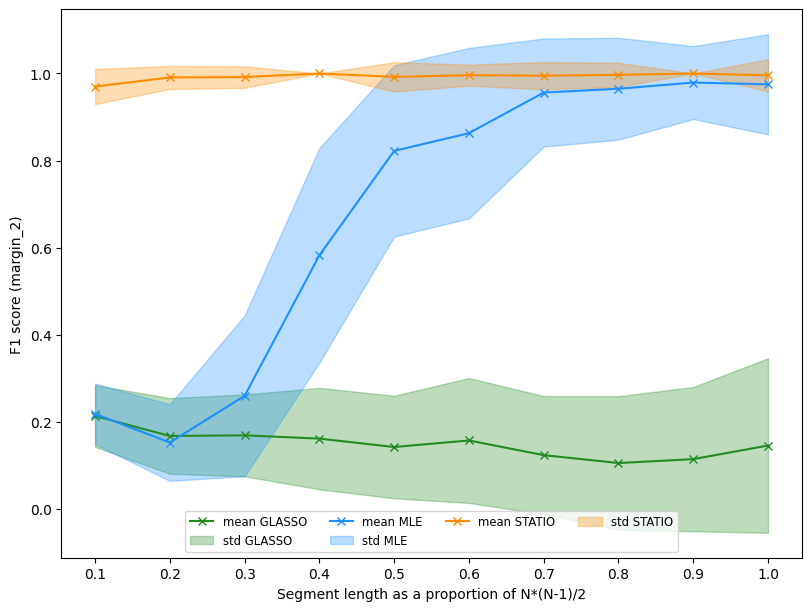

In [12]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/SNR_20_varying_segment_length"
folder_name_list = os.listdir(res_folder_root)
res_folder_list = [os.path.join(res_folder_root, folder_name) for folder_name in folder_name_list]
res_folder_list.sort()
#-------------------------------------------------------------------------------------------

# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys = ["lasso_penmultcoef_4.0_pred", "standard_mle_pred", "statio_pred"] #"covcp_windsize_80_stableset_80", 
metric_name = "margin_2"
metric_per_method = get_res_per_method(res_folder_list, method_keys, metric_name)
#-------------------------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
ax = standard_plot_plus_fill_between(method_keys, res_dic=metric_per_method, colors_per_method=COLORS_PER_COST_FUNC, ax=ax, to_label=True)

# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels = [str(i/10) for i in range(1, 11)]
x_tick_pos = list(range(1, 11))
ax.set_xticks(x_tick_pos, x_tick_labels)

ax.set_xlabel('Segment length as a proportion of N*(N-1)/2')
y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
if 'assignement' in metric_name:
    y_label = 'assignment cost'
ax.set_ylabel(y_label)

ax.legend(loc='lower center', ncols=4, fontsize='small')
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/{res_folder_root.split('/')[-1]}"
    plot_name = y_label 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}.pdf")
    plt.savefig(f"{plot_path}/{plot_name}")
# #-------------------------------------------------------------------------------------------

['results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.0', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.4', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.6', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.8', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_other_ER_graph', 'results_1/synthetic

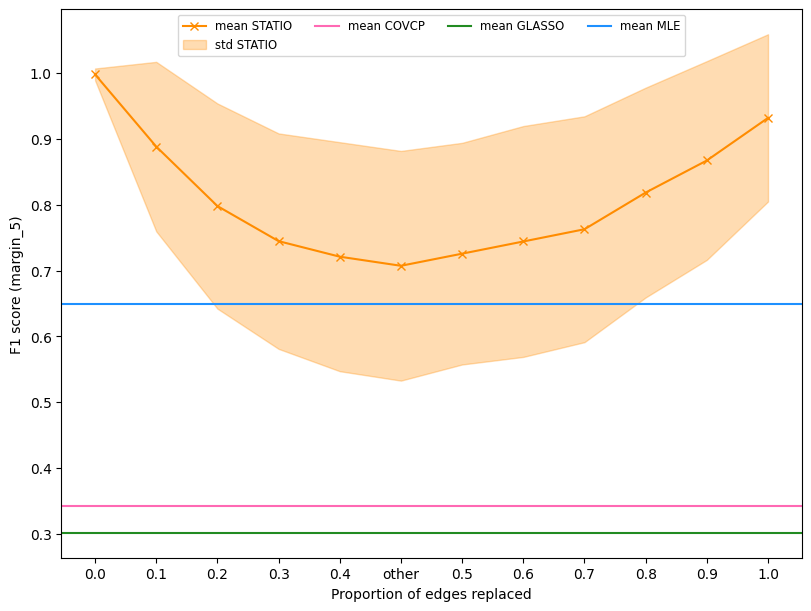

In [45]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced"
folder_name_list = os.listdir(res_folder_root)
res_folder_list = [os.path.join(res_folder_root, folder_name) for folder_name in folder_name_list]
res_folder_list.remove('results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_other_ER_graph')
res_folder_list.sort()
res_folder_list.insert(5, 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_other_ER_graph')
#-------------------------------------------------------------------------------------------

print(res_folder_list)

# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys = ["statio_pred"]
metric_name = "margin_5"
metric_per_method = get_res_per_method(res_folder_list, method_keys, metric_name)
#-------------------------------------------------------------------------------------------

# RETRIEVING OTHER METHOD RESULTS
#-------------------------------------------------------------------------------------------
other_methods_names = ["covcp_windsize_80_stableset_80", "lasso_penmultcoef_4.0_pred", "standard_mle_pred"]
other_method_folder_path = ['results_1/synthetic/within_hypothesis_noisy/SNR_20_varying_segment_length/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4']
other_methods_metric = get_res_per_method(other_method_folder_path, other_methods_names, metric_name)
#-------------------------------------------------------------------------------------------


fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
ax = standard_plot_plus_fill_between(method_keys, res_dic=metric_per_method, colors_per_method=COLORS_PER_COST_FUNC, ax=ax, to_label=True)


# ADDING OTHER METHODS MEAN
#-------------------------------------------------------------------------------------------
for method_name in other_methods_names:
    ax.axhline(y = other_methods_metric[method_name]['mean'], c = COLORS_PER_COST_FUNC[method_name], label= 'mean ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name])
#-------------------------------------------------------------------------------------------


# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels = [str(i/20) for i in range(0, 10, 2)] + ['other'] + [str(i/20) for i in range(10, 22, 2)]
x_tick_pos = list(range(1, 13))
ax.set_xticks(x_tick_pos, x_tick_labels)

ax.set_xlabel('Proportion of edges replaced')
y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
ax.set_ylabel(y_label)

ax.legend(loc='upper center', ncols=4, fontsize='small')
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/{res_folder_root.split('/')[-3]}_{res_folder_root.split('/')[-1]}"
    plot_name =   y_label 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
# #-------------------------------------------------------------------------------------------

{'statio_pred': {'mean': [0.7846, 0.4411, 0.3497, 0.2969, 0.288, 0.2758], 'std': [0.1081, 0.2027, 0.1808, 0.1639, 0.1675, 0.1636], 'raw': [[0.7073, 1.0, 0.7368, 0.7632, 0.65, 0.641, 0.8158, 0.8684, 0.6923, 1.0, 0.675, 0.675, 0.7632, 1.0, 0.7368, 1.0, 0.7368, 0.8718, 0.7368, 0.7179, 0.8, 0.7632, 0.814, 0.7949, 0.7838, 1.0, 0.7179, 0.7568, 0.65, 0.65, 0.725, 0.7568, 0.7632, 0.7692, 0.8421, 0.7692, 0.6667, 0.7895, 0.641, 1.0, 1.0, 0.7895, 0.7436, 0.7692, 0.7949, 0.7895, 1.0, 0.6829, 0.7297, 1.0, 0.7692, 0.7, 0.6429, 0.641, 0.8158, 0.7805, 0.7895, 0.7692, 0.8, 0.7368, 0.6, 0.7692, 0.7632, 0.7838, 0.6585, 0.7436, 0.7895, 0.8378, 0.6923, 1.0, 0.6667, 0.7027, 0.7027, 0.8108, 0.9189, 0.7692, 1.0, 0.725, 0.8462, 1.0], [0.7778, 0.3333, 0.2222, 0.1111, 0.3, 0.4444, 0.625, 0.3333, 0.3333, 0.7778, 0.75, 0.4444, 0.125, 0.6, 0.5714, 0.3, 0.25, 0.5, 0.375, 0.2857, 0.6667, 0.2222, 1.0, 0.4444, 0.2222, 0.4444, 0.7778, 0.6, 0.5, 0.375, 0.375, 0.4444, 0.6, 0.5, 0.625, 0.5556, 0.5556, 0.6, 0.6667, 0.4444, 

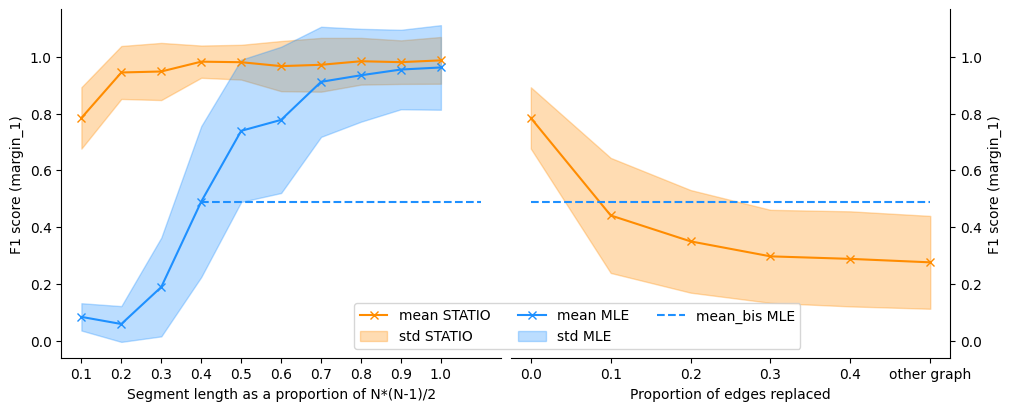

In [57]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root_graph_knowledge = "results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced"
folder_name_list_graph_knowledge = os.listdir(res_folder_root_graph_knowledge)
res_folder_list_graph_knowledge = [os.path.join(res_folder_root_graph_knowledge, folder_name) for folder_name in folder_name_list_graph_knowledge]
res_folder_list_graph_knowledge.remove('results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_other_ER_graph')
res_folder_list_graph_knowledge.sort()
res_folder_list_graph_knowledge.insert(5, 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_replaced/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_other_ER_graph')
res_folder_list_graph_knowledge = res_folder_list_graph_knowledge[:6]

res_folder_root_seg_length = "results_1/synthetic/within_hypothesis_noisy/SNR_20_varying_segment_length"
folder_name_list_seg_length = os.listdir(res_folder_root_seg_length)
res_folder_list_seg_length = [os.path.join(res_folder_root_seg_length, folder_name) for folder_name in folder_name_list_seg_length]
res_folder_list_seg_length.sort()
#-------------------------------------------------------------------------------------------


# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys_graph_konwledge = ["statio_pred"]
method_keys_seg_length = ["statio_pred", "standard_mle_pred"]
metric_name = "margin_1"
metric_per_method_graph_knowledge = get_res_per_method(res_folder_list_graph_knowledge, method_keys_graph_konwledge, metric_name)
metric_per_method_seg_length = get_res_per_method(res_folder_list_seg_length, method_keys_seg_length, metric_name)
#-------------------------------------------------------------------------------------------

# RETRIEVING OTHER METHOD RESULTS
#-------------------------------------------------------------------------------------------
other_methods_names = [ "standard_mle_pred"]
other_method_folder_path = ['results_1/synthetic/within_hypothesis_noisy/SNR_20_varying_segment_length/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4']
other_methods_metric = get_res_per_method(other_method_folder_path, other_methods_names, metric_name)
#-------------------------------------------------------------------------------------------

print(metric_per_method_graph_knowledge)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), layout='constrained', sharey=True)
ax1 = standard_plot_plus_fill_between(method_keys_seg_length, res_dic=metric_per_method_seg_length, colors_per_method=COLORS_PER_COST_FUNC, ax=ax1, to_label=True)
ax2 = standard_plot_plus_fill_between(method_keys_graph_konwledge, res_dic=metric_per_method_graph_knowledge, colors_per_method=COLORS_PER_COST_FUNC, ax=ax2, to_label=False)


# ADDING OTHER METHODS MEAN
#-------------------------------------------------------------------------------------------
for method_name in other_methods_names:
    ax2.hlines(y = other_methods_metric[method_name]['mean'], colors = COLORS_PER_COST_FUNC[method_name], label= 'mean_bis ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name], linestyles='dashed', xmin=1, xmax=6)
    ax1.hlines(y = other_methods_metric[method_name]['mean'], colors = COLORS_PER_COST_FUNC[method_name], linestyles='dashed', xmin=4, xmax=11)
#-------------------------------------------------------------------------------------------


# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels_seg_length = [str(i/10) for i in range(1, 11)] 
x_tick_pos = list(range(1, 11))
ax1.set_xticks(x_tick_pos, x_tick_labels_seg_length)
ax1.set_xlabel('Segment length as a proportion of N*(N-1)/2')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

x_tick_labels_graph = [str(i/20) for i in range(0, 10, 2)] + ['other graph'] 
x_tick_pos_graph = list(range(1, 7))
ax2.set_xticks(x_tick_pos_graph, x_tick_labels_graph)
ax2.set_xlabel('Proportion of edges replaced')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
ax1.set_ylabel(y_label)
ax2.set_ylabel(y_label)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.yaxis.set_tick_params(labelright=True)

fig.legend(loc=(0.35, 0.15), ncols=3)
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/ablation_study_{res_folder_root_graph_knowledge.split('/')[-1]}"
    plot_name = y_label + 'dashed_line' 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
    plt.savefig(f"{plot_path}/{plot_name}.pdf")


['results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_00', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.1', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.3', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.4', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.5', 'results_1/synthetic/within_hypot

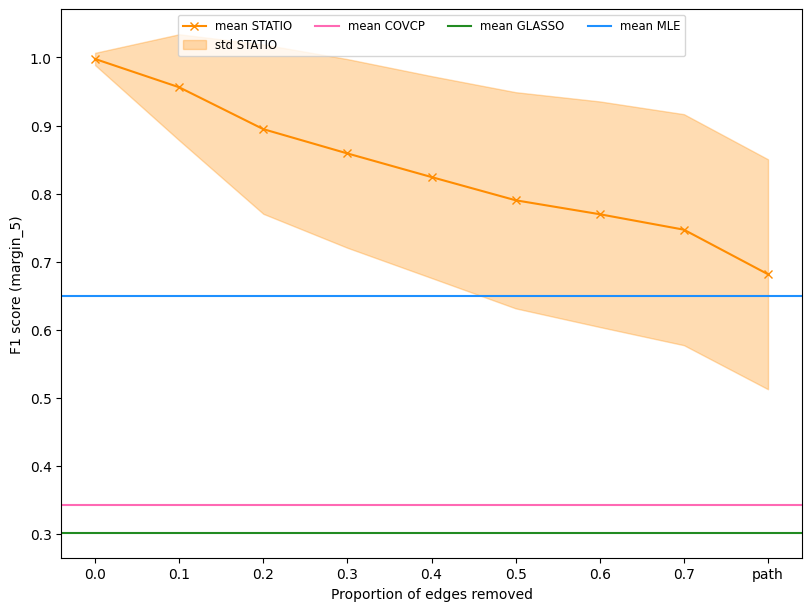

In [44]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed"
folder_name_list = os.listdir(res_folder_root)
res_folder_list = [
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_00', 
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.1',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.3',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.4',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.5',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.6',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.7',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_removed/large_x0.4_SNR_20_path_graph',
]
#-------------------------------------------------------------------------------------------

print(res_folder_list)

# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys = ["statio_pred"]
metric_name = "margin_5"
metric_per_method = get_res_per_method(res_folder_list, method_keys, metric_name)
#-------------------------------------------------------------------------------------------

# RETRIEVING OTHER METHOD RESULTS
#-------------------------------------------------------------------------------------------
other_methods_names = ["covcp_windsize_80_stableset_80", "lasso_penmultcoef_4.0_pred", "standard_mle_pred"]
other_method_folder_path = ['results_1/synthetic/within_hypothesis_noisy/SNR_20_varying_segment_length/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4']
other_methods_metric = get_res_per_method(other_method_folder_path, other_methods_names, metric_name)
#-------------------------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
ax = standard_plot_plus_fill_between(method_keys, res_dic=metric_per_method, colors_per_method=COLORS_PER_COST_FUNC, ax=ax, to_label=True)

# ADDING OTHER METHODS MEAN
#-------------------------------------------------------------------------------------------
for method_name in other_methods_names:
    ax.axhline(y = other_methods_metric[method_name]['mean'], c = COLORS_PER_COST_FUNC[method_name], label= 'mean ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name])
#-------------------------------------------------------------------------------------------


# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels = [str(i/10) for i in range(0, 8)] + ['path']
x_tick_pos = list(range(1, 10))
ax.set_xticks(x_tick_pos, x_tick_labels)

ax.set_xlabel('Proportion of edges removed')
y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
ax.set_ylabel(y_label)

ax.legend(loc='upper center', ncols=4, fontsize='small')
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/{res_folder_root.split('/')[-3]}_{res_folder_root.split('/')[-1]}"
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plot_name = y_label 
    plt.savefig(f"{plot_path}/{plot_name}")
    plt.savefig(f"{plot_path}/{plot_name}.pdf")
# #-------------------------------------------------------------------------------------------

['results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_00', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.1', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.3', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.4', 'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.5', 'results_1/synthetic/within_hypothesis_n

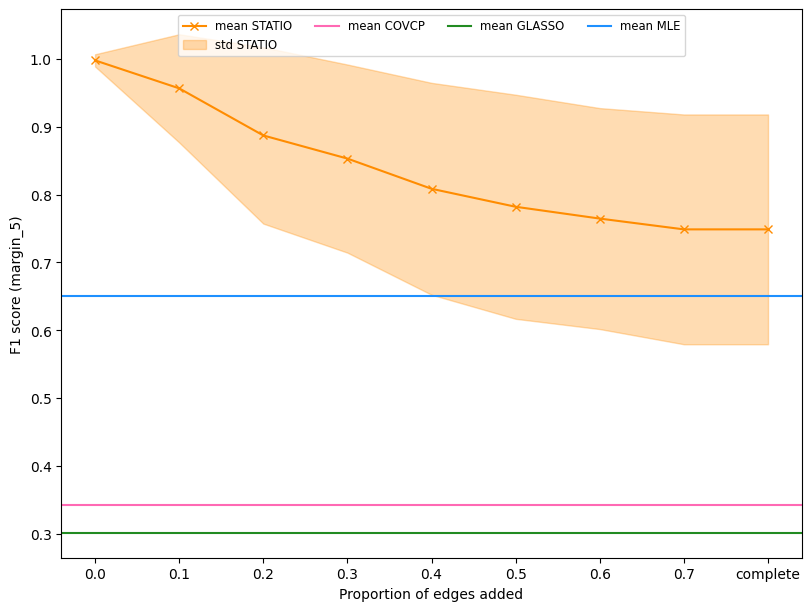

In [43]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added"
folder_name_list = os.listdir(res_folder_root)
res_folder_list = [
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_00', 
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.1',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.3',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.4',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.5',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.6',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.7',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_complete_graph',
]
#-------------------------------------------------------------------------------------------

print(res_folder_list)

# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys = ["statio_pred"]
metric_name = "margin_5"
metric_per_method = get_res_per_method(res_folder_list, method_keys, metric_name)
#-------------------------------------------------------------------------------------------

# RETRIEVING OTHER METHOD RESULTS
#-------------------------------------------------------------------------------------------
other_methods_names = ["covcp_windsize_80_stableset_80", "lasso_penmultcoef_4.0_pred", "standard_mle_pred"]
other_method_folder_path = ['results_1/synthetic/within_hypothesis_noisy/SNR_20_varying_segment_length/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4']
other_methods_metric = get_res_per_method(other_method_folder_path, other_methods_names, metric_name)
#-------------------------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
ax = standard_plot_plus_fill_between(method_keys, res_dic=metric_per_method, colors_per_method=COLORS_PER_COST_FUNC, ax=ax, to_label=True)

# ADDING OTHER METHODS MEAN
#-------------------------------------------------------------------------------------------
for method_name in other_methods_names:
    ax.axhline(y = other_methods_metric[method_name]['mean'], c = COLORS_PER_COST_FUNC[method_name], label= 'mean ' + COST_FUNC_NAME_TO_PLOT_LABEL[method_name])
#-------------------------------------------------------------------------------------------

# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels = [str(i/10) for i in range(0, 8)] + ['complete']
x_tick_pos = list(range(1, 10))
ax.set_xticks(x_tick_pos, x_tick_labels)

ax.set_xlabel('Proportion of edges added')
y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
ax.set_ylabel(y_label)

ax.legend(loc='upper center', ncols=4, fontsize='small')
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/{res_folder_root.split('/')[-3]}_{res_folder_root.split('/')[-1]}"
    plot_name =   y_label 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
# #-------------------------------------------------------------------------------------------

{'statio_pred': {'mean': [0.9991, 0.9892, 0.9555, 0.936, 0.9079, 0.8956, 0.8788, 0.8641, 0.8641], 'std': [0.0048, 0.0352, 0.0798, 0.0919, 0.1134, 0.117, 0.1241, 0.131, 0.131], 'raw': [[1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9762, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9737, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.8889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8889, 1.0, 1.0, 0.8889, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8889, 1.0, 1.0, 

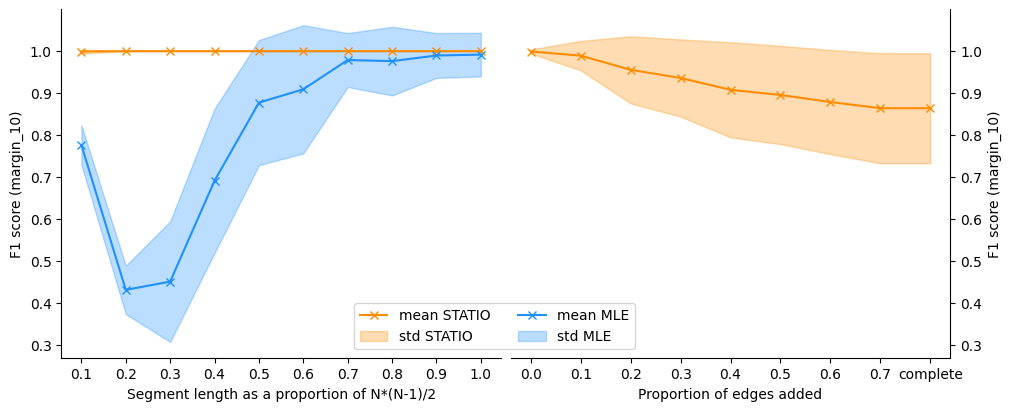

In [33]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root_graph_knowledge = "results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added"
res_folder_list_graph_knowledge = [
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_00', 
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.1',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.2',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.3',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.4',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.5',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.6',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4_edge_prop_0.7',
    'results_1/synthetic/within_hypothesis_noisy/graph_connec_modif/ER_graphs/SNR_20_edges_added/large_x0.4_SNR_20_complete_graph',
]

res_folder_root_seg_length = "results_1/synthetic/within_hypothesis_noisy/SNR_20_varying_segment_length"
folder_name_list_seg_length = os.listdir(res_folder_root_seg_length)
res_folder_list_seg_length = [os.path.join(res_folder_root_seg_length, folder_name) for folder_name in folder_name_list_seg_length]
res_folder_list_seg_length.sort()
#-------------------------------------------------------------------------------------------


# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys_graph_konwledge = ["statio_pred"]
method_keys_seg_length = ["statio_pred", "standard_mle_pred"]
metric_name = "margin_10"
metric_per_method_graph_knowledge = get_res_per_method(res_folder_list_graph_knowledge, method_keys_graph_konwledge, metric_name)
metric_per_method_seg_length = get_res_per_method(res_folder_list_seg_length, method_keys_seg_length, metric_name)
#-------------------------------------------------------------------------------------------

print(metric_per_method_graph_knowledge)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), layout='constrained', sharey=True)
ax1 = standard_plot_plus_fill_between(method_keys_seg_length, res_dic=metric_per_method_seg_length, colors_per_method=COLORS_PER_COST_FUNC, ax=ax1, to_label=True)
ax2 = standard_plot_plus_fill_between(method_keys_graph_konwledge, res_dic=metric_per_method_graph_knowledge, colors_per_method=COLORS_PER_COST_FUNC, ax=ax2, to_label=False)


# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels_seg_length = [str(i/10) for i in range(1, 11)] 
x_tick_pos = list(range(1, 11))
ax1.set_xticks(x_tick_pos, x_tick_labels_seg_length)
ax1.set_xlabel('Segment length as a proportion of N*(N-1)/2')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

x_tick_labels_graph = [str(i/10) for i in range(0, 8)] + ['complete']
x_tick_pos_graph = list(range(1, 10))
ax2.set_xticks(x_tick_pos_graph, x_tick_labels_graph)
ax2.set_xlabel('Proportion of edges added')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
ax1.set_ylabel(y_label)
ax2.set_ylabel(y_label)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.yaxis.set_tick_params(labelright=True)

fig.legend(loc=(0.35, 0.15), ncols=2)
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/ablation_study_{res_folder_root_graph_knowledge.split('/')[-1]}"
    plot_name =   y_label 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
    plt.savefig(f"{plot_path}/{plot_name}.pdf")


['results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_-5_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_-1_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_0_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_1_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_5_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_10_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_15_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4']


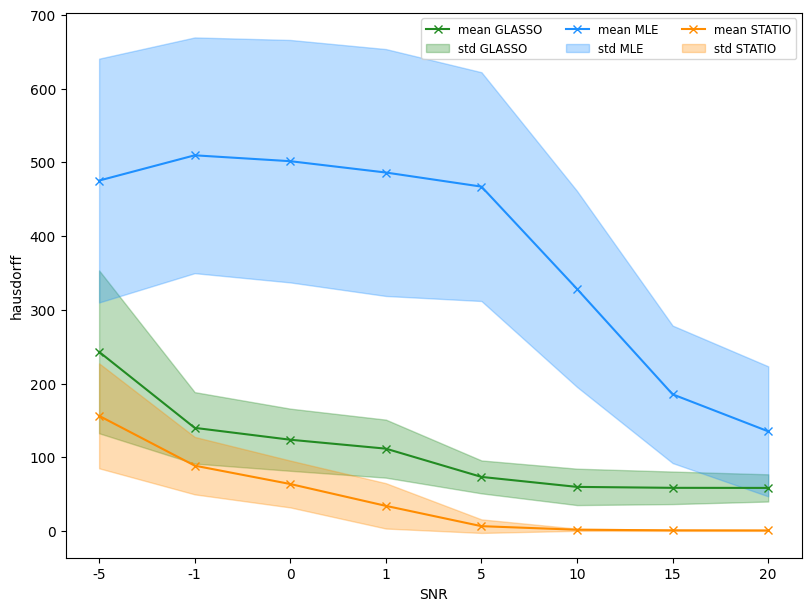

In [51]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp"
folder_name_list = os.listdir(res_folder_root)
res_folder_list = [
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_-5_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_-1_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_0_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_1_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_5_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_10_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_15_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/varying_SNR_within_hyp/large_x0.4_SNR_20_ER_20_nodes_deg_10_bandwidth_0.4',
]
#-------------------------------------------------------------------------------------------

print(res_folder_list)

# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys = ["lasso_penmultcoef_4.0_pred", "standard_mle_pred", "statio_pred"] #, "covcp_windsize_80_stableset_80"]
metric_name = "hausdorff"
metric_per_method = get_res_per_method(res_folder_list, method_keys, metric_name)
#-------------------------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
ax = standard_plot_plus_fill_between(method_keys, res_dic=metric_per_method, colors_per_method=COLORS_PER_COST_FUNC, ax=ax, to_label=True)

# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels = ['-5', '-1', '0', '1', '5', '10', '15', '20']
x_tick_pos = list(range(1, 9))
ax.set_xticks(x_tick_pos, x_tick_labels)

ax.set_xlabel('SNR')
y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
ax.set_ylabel(y_label)

ax.legend(loc='upper right', ncols=3, fontsize='small')
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/{res_folder_root.split('/')[-1]}"
    plot_name = y_label 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
# #-------------------------------------------------------------------------------------------

['results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_2_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_4_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_6_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_8_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_10_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_12_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4', 'results_1/sy

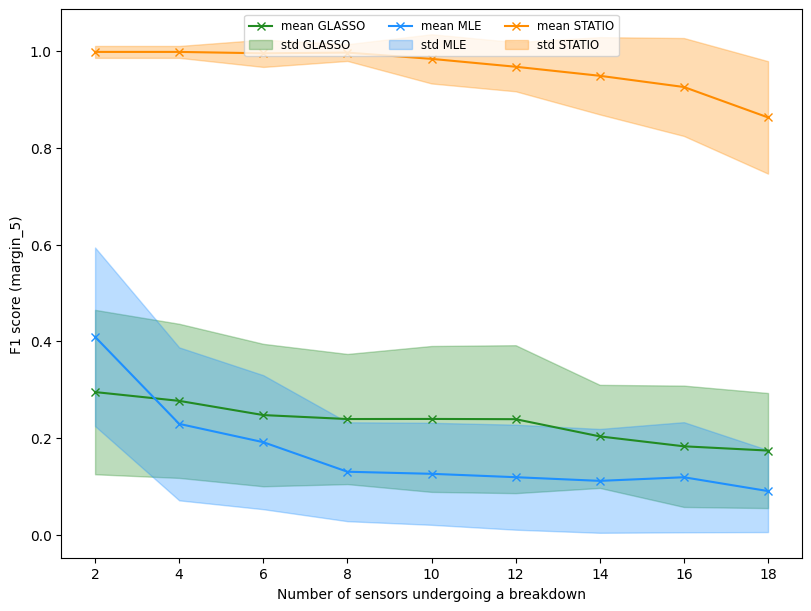

In [78]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_root = "results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns"
folder_name_list = os.listdir(res_folder_root)
res_folder_list = [
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_2_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_4_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_6_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_8_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_10_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_12_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_14_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_16_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
    'results_1/synthetic/within_hypothesis_noisy/SNR_20_sensor_breakdown/varying_nb_breakdowns/large_x0.4_SNR_20_NBbd_18_bklength_300_ER_20_nodes_deg_10_bandwidth_0.4',
]
#-------------------------------------------------------------------------------------------

print(res_folder_list)

# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys = ["lasso_penmultcoef_4.0_pred", "standard_mle_pred", "statio_pred"]
metric_name = "margin_5"
metric_per_method = get_res_per_method(res_folder_list, method_keys, metric_name)
#-------------------------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
ax = standard_plot_plus_fill_between(method_keys, res_dic=metric_per_method, colors_per_method=COLORS_PER_COST_FUNC, ax=ax, to_label=True)

# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels = [i for i in range(2, 20, 2)]
x_tick_pos = list(range(1, 10))
ax.set_xticks(x_tick_pos, x_tick_labels)

ax.set_xlabel('Number of sensors undergoing a breakdown')
y_label = metric_name
if "margin" in metric_name:
    y_label = f'F1 score ({metric_name})' 
ax.set_ylabel(y_label)

ax.legend(loc='upper center', ncols=3, fontsize='small')
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/{res_folder_root.split('/')[-2]}_{res_folder_root.split('/')[-1]}"
    plot_name = y_label 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
# #-------------------------------------------------------------------------------------------

{'margin_1': {'covcp_windsize_80_stableset_80': {'mean': [0.011], 'std': [0.0208], 'raw': [[0.0, 0.0, 0.0392, 0.0, 0.0435, 0.0, 0.0, 0.0364, 0.0, 0.0351, 0.0, 0.0351, 0.0, 0.0, 0.0351, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.069, 0.0, 0.0727, 0.0, 0.0, 0.0, 0.0, 0.0351, 0.0, 0.0345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0377, 0.0, 0.0, 0.0, 0.0357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0351, 0.0357, 0.0345, 0.0, 0.0392, 0.0, 0.0357, 0.0, 0.0, 0.0, 0.0417, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0392, 0.0, 0.037, 0.0, 0.0, 0.0377, 0.0, 0.0, 0.0, 0.0, 0.0364, 0.0, 0.0, 0.0, 0.037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0364, 0.0, 0.037, 0.0, 0.0, 0.0364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0377, 0.0, 0.0364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0357, 0.0357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

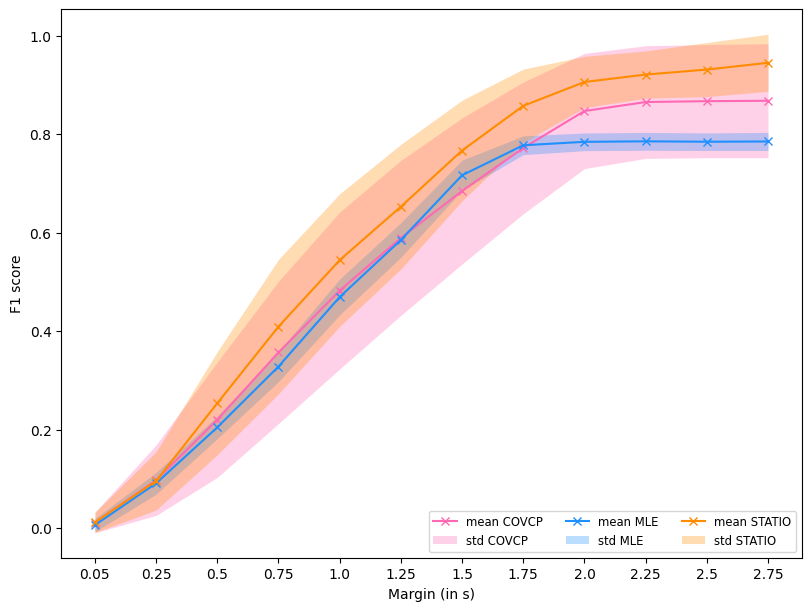

In [76]:
TO_SAVE = False

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_list = ["results_1/real_data/eeg_movement/special_metrics/filtered_0.5-40_order_3_subsampled_8"]
#-------------------------------------------------------------------------------------------

# RETIEVING DATA
#-------------------------------------------------------------------------------------------
method_keys = ["covcp_windsize_80_stableset_80", "standard_mle_pred", "statio_pred"]
margins_val = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
metric_names = ['margin_' + str(i) for i in margins_val]
per_margin_res_dic = {}
for metric_name in metric_names:
    per_margin_res_dic[metric_name] = get_res_per_method(res_folder_list,  method_keys, metric_name, file_name='overall_mean_until_60.json')
#-------------------------------------------------------------------------------------------

print(per_margin_res_dic)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
ax = standard_plot_plus_fill_between_wrt_margin(method_keys, per_margin_res_dic, COLORS_PER_COST_FUNC, preci_margin_list=metric_names, ax=ax, to_label=True, )

# PLOT ELEMENTS
#-------------------------------------------------------------------------------------------
x_tick_labels = [i / 20 for i in margins_val]
x_tick_pos = list(range(1, 13))
ax.set_xticks(x_tick_pos, x_tick_labels)

ax.set_xlabel('Margin (in s)')
y_label = f'F1 score' 
ax.set_ylabel(y_label)

ax.legend(loc='lower right', ncols=3, fontsize='small')
#-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/eeg-movement/{res_folder_list[0].split('/')[-1]}"
    plot_name = 'overall_mean_until_60'
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
# #-------------------------------------------------------------------------------------------

{'margin_1': {'covcp_windsize_80_stableset_80': {'mean': [0.0089], 'std': [0.0181], 'raw': [[0.0, 0.0435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0345, 0.0, 0.0, 0.0377, 0.0357, 0.0, 0.0351, 0.0392, 0.0, 0.0, 0.0, 0.0, 0.0377, 0.0, 0.0, 0.0, 0.0, 0.0364, 0.0, 0.0, 0.0, 0.0, 0.0357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0345, 0.0, 0.0, 0.0351, 0.0, 0.0, 0.0, 0.0, 0.0345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0435, 0.0, 0.0357, 0.0, 0.037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0351, 0.0, 0.0, 0.0, 0.0, 0.0385, 0.0, 0.0, 0.0, 0.0784, 0.0, 0.0, 0.0357, 0.0, 0.0357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0364, 0.0, 0.0357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0952, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.069, 0.0, 0.0351, 0.0, 0.0, 0.0, 0.0351, 0.037, 0.0, 0.0385, 0.0345, 0.0, 0.0385, 0.0, 0.0, 0.0, 0.0357, 0.0, 0.0, 0.0, 0.0, 0.0364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0345, 0.0, 0.0, 0.0, 0.0345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0392, 0.0, 

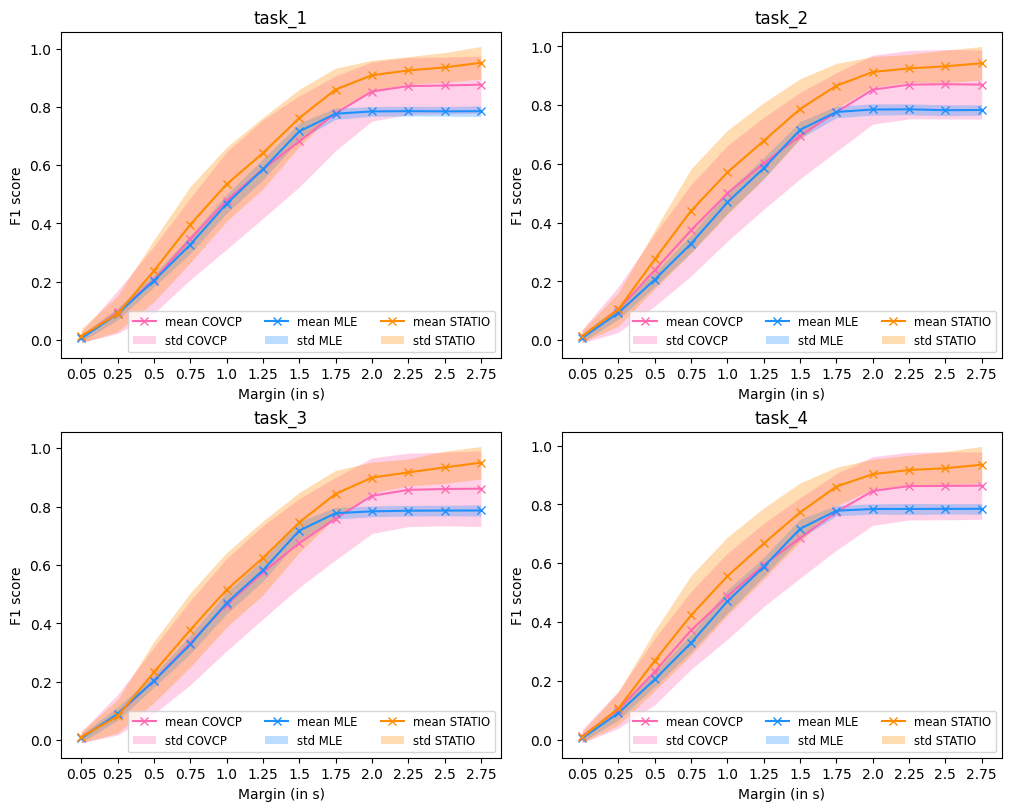

In [77]:
TO_SAVE = False

fig, axes = plt.subplots(2, 2, figsize=(10, 8), layout='constrained')

# EXPERIMENT PARSING
#-------------------------------------------------------------------------------------------
res_folder_list = ["results_1/real_data/eeg_movement/special_metrics/filtered_0.5-40_order_3_subsampled_8"]
#-------------------------------------------------------------------------------------------

for ax_id, task_id in enumerate(['task_1', 'task_2', 'task_3', 'task_4']):

    ax = axes[ax_id//2, ax_id%2]

    # RETIEVING DATA
    #-------------------------------------------------------------------------------------------
    method_keys = ["covcp_windsize_80_stableset_80", "standard_mle_pred", "statio_pred"]
    margins_val = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
    metric_names = ['margin_' + str(i) for i in margins_val]
    per_margin_res_dic = {}
    for metric_name in metric_names:
        per_margin_res_dic[metric_name] = get_res_per_method(res_folder_list,  method_keys, metric_name, file_name=f'{task_id}_mean_until_60.json')
    #-------------------------------------------------------------------------------------------

    print(per_margin_res_dic)

    ax = standard_plot_plus_fill_between_wrt_margin(method_keys, per_margin_res_dic, COLORS_PER_COST_FUNC, preci_margin_list=metric_names, ax=ax, to_label=True, )

    # PLOT ELEMENTS
    #-------------------------------------------------------------------------------------------
    x_tick_labels = [i / 20 for i in margins_val]
    x_tick_pos = list(range(1, 13))
    ax.set_xticks(x_tick_pos, x_tick_labels)

    ax.set_xlabel('Margin (in s)')
    y_label = f'F1 score' 
    ax.set_ylabel(y_label)

    ax.legend(loc='lower right', ncols=3, fontsize='small')
    ax.set_title(task_id)
    #-------------------------------------------------------------------------------------------

# PLOT SAVING
#-------------------------------------------------------------------------------------------
if TO_SAVE:
    metadata = get_metadata_for_plot(res_folder_list)
    plot_path = f"images/results_1/eeg-movement/{res_folder_list[0].split('/')[-1]}"
    plot_name = 'per_task_mean_until_60' 
    my_ut.create_parent_and_dump_json(plot_path, f'{plot_name}.json', metadata, indent=4)
    plt.savefig(f"{plot_path}/{plot_name}")
# #-------------------------------------------------------------------------------------------